Authors: 

Jonathan Naumanen

Adam Williams

Group 17

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

In [3]:
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id

In [4]:
from graphviz import Digraph
from sklearn.base import BaseEstimator, RegressorMixin
from abc import ABC, abstractmethod

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth
        
    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

In [5]:
def var_calc (varsum, varsq, varc):
    return (varsq / varc) - (varsum / varc)**2 

In [6]:
def var_score (low_var, high_var, low_count, high_count, n):
    return (-(low_var * low_count + high_var * high_count) / n)

In [7]:
class TreeRegressor(DecisionTree, RegressorMixin):
    # threshold is initialized to 1e - 6 and max_depth to 5
    def __init__(self, max_depth=5, threshold = 1e-6):
        super().__init__(max_depth)
        self.threshold = threshold
        self.default_value = None
        
    def fit(self, X, Y):
        super().fit(X, Y)
        

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the mean.
    def get_default_value(self, Y):
        self.class_distribution = np.mean(Y)
        return self.class_distribution
    
    # Checks whether a set of output values is homogeneous. In the regression case, 
    # this means that the variance of the output values are lesser than a threshold.
    
    def is_homogeneous(self, Y):
        return(np.var(Y) < self.threshold)
        
    # Finds the best splitting point for a given feature. 
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        #Keep track of low sum, low sum squared, high sum, high sum squared
        low_sum = 0
        low_sum_sq = 0
        low_count = 0

        high_sum = sum(Y)
        high_sum_sq = sum(Y**2)
        high_count = n

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # Update low and and high
            low_sum += y_i
            low_sum_sq += y_i**2
            low_count += 1

            high_sum -= y_i
            high_sum_sq -= y_i**2
            high_count -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the var and score for split

            low_var = var_calc(low_sum, low_sum_sq, low_count)
            high_var = var_calc(high_sum, high_sum_sq, high_count)

            score = var_score(low_var, high_var, low_count, high_count, n)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point


Step 2.

In [8]:
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1*np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y

For the report: We decided to represent this data with a regression type of decision tree. Regression models are used for training on numerical data which is what we are doing.

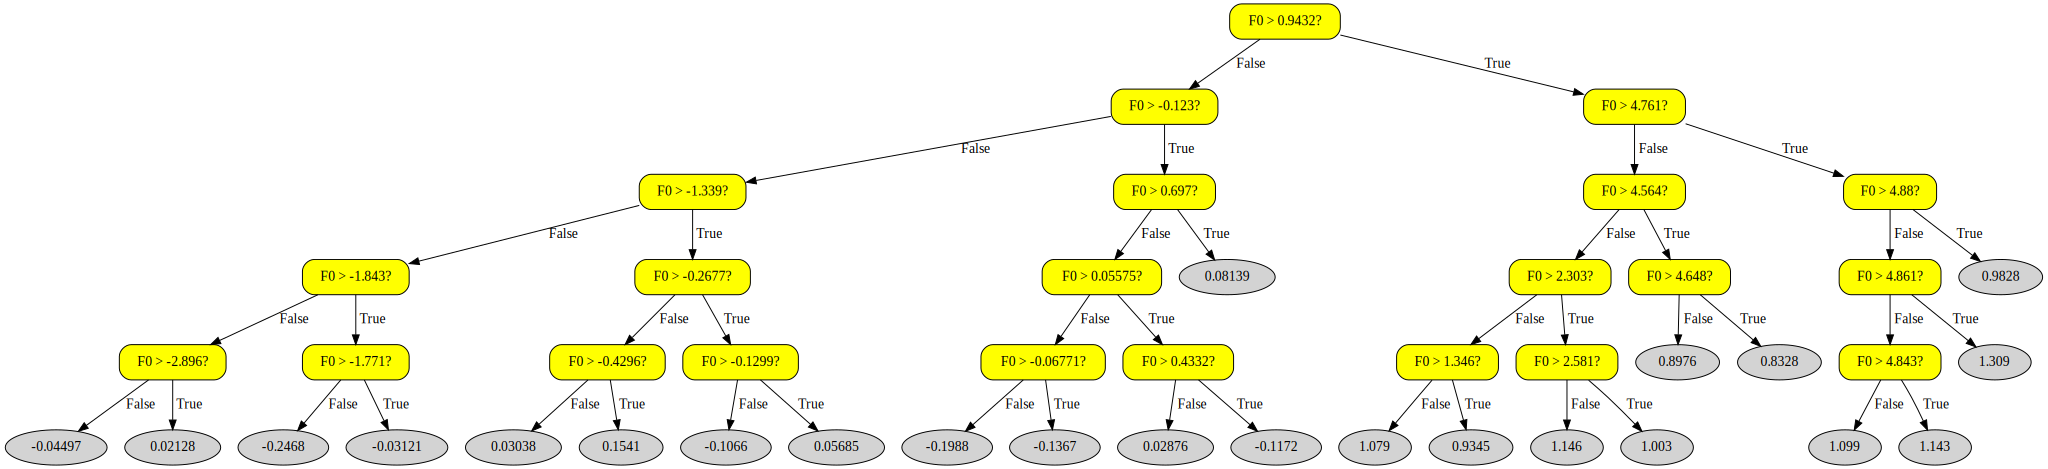

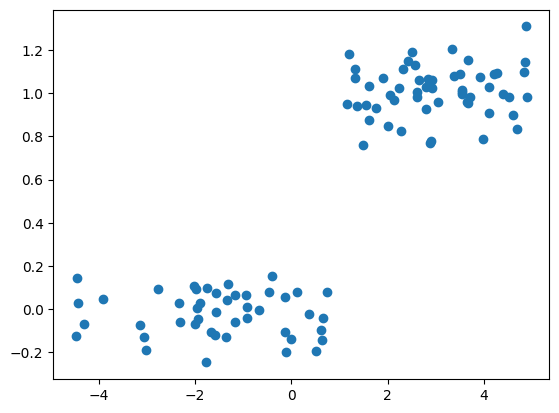

In [9]:
X, Y = make_some_data(100)

plt.scatter(X,Y)

TR = TreeRegressor()

TR.fit(X,Y)
TR.draw_tree()

Q. Does the result make sense? What happens if we allow the tree depth to be a large number?

Answer: The nodes compare float values and are therefore not easily interpreted. The tree model makes the first split on the parent node around x = 1 which makes sense if you look at the data in the scatterplot. Later splits are harder to make sense of as the data seems to be random(within a certain interval) past the first split. 

If we increase tree depth the model will be overfitted to the training set and the tree grows larger. 

Step 3.

In [10]:
from sklearn.model_selection import train_test_split
# Read the CSV file using Pandas.
alldata = pd.read_csv('sberbank.csv')

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=42)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.33, random_state=42)

TR score: 0.28324659050930345


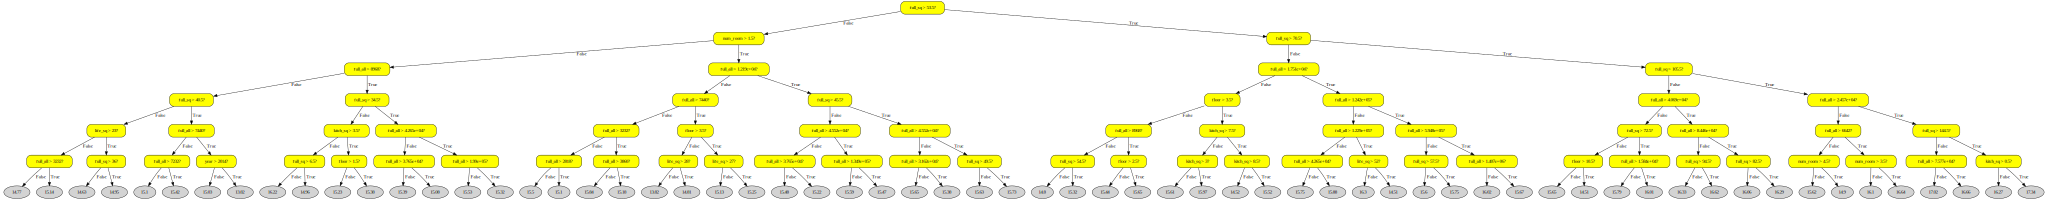

In [11]:
from sklearn.metrics import mean_squared_error
TR = TreeRegressor(max_depth=6)

TR.fit(Xtrain,Ytrain)

score = mean_squared_error(Ytest, TR.predict(Xtest))
print(f"TR score: {score:}")
TR.draw_tree()

For the report: We used tree depth 6 and got the evaluation score 0.2809846979481583. We used 6 as max_depth which gave us the best evaluation score.

Step 4.

In [12]:
def plot_eval_scores(max_depths, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    for i in max_depths:
        
        TR = TreeRegressor(max_depth= i)
        TR.fit(Xtrain, Ytrain)

        train_score = mean_squared_error(Ytrain, TR.predict(Xtrain))
        test_score = mean_squared_error(Ytest, TR.predict(Xtest))

        train_scores.append(train_score)
        test_scores.append(test_score)


    plt.plot(max_depths, train_scores, "b-", label="Training set")
    plt.plot(max_depths, test_scores, "r--", label="Test set")
    plt.xlabel("Max depth")
    plt.ylabel("Mean squared error")
    plt.legend()
    plt.show()

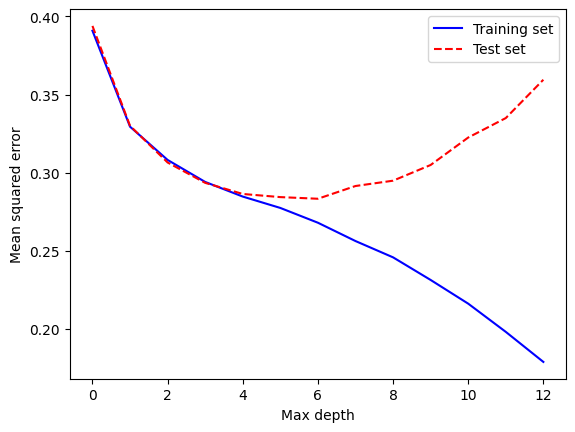

In [13]:
max_depths = np.arange(0, 13)
plot_eval_scores(max_depths,Xtrain,Ytrain,Xtest,Ytest)

For the report: The model is underfitting at depth 4 and lower, where there is no difference between the training and test score. The model performs best at depth 6 and is performing worse the higher we tune the depth, due to overfitting.

The training set scores lower (and therefore better) the higher the depth, this is due to overfitting as the model gets more specific when training on the training set but this makes it worse in the general predictions which are clear by the test set plot scoring higher (and therefore worse) from depth 6 and onwards.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=190ad4d2-4321-416d-9847-7401b32c451a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>